# Extract eICU Time Series Data
Those features are considered:
* Heart Rate
* Respiratory Rate
* SpO2 (oxygen saturation, it's actually SpO2 although it's called SaO2, see official paper for details)
* Mean Blood Pressure

Didn't consider systolic pressure and diastolic pressure since they are used to calculate mean blood pressure, and they follow the same trend for most of the time

Pre-req: build eICU database and run `sql/patient_id.sql`

In [1]:
from helpers import DataBaseLoader
load = DataBaseLoader(user='mt361', password='tian01050417', dbname='eicu_gen', schema='eicu')

SQL_SCRIPT = """
SELECT
	vitalPeriodic.patientunitstayid,
	observationoffset,
	heartrate,
	CASE
		WHEN heartrate IS NULL THEN 1
		ELSE 0
	END AS heartrate_null,
	respiration,
	CASE
		WHEN respiration IS NULL THEN 1
		ELSE 0
	END AS respiration_null,
	sao2,
	CASE
		WHEN sao2 IS NULL THEN 1
		ELSE 0
	END AS sao2_null,
	systemicMean,
	CASE
		WHEN systemicMean IS NULL THEN 1
		ELSE 0
	END AS systemicmean_null
 
FROM vitalPeriodic

WHERE vitalPeriodic.patientunitstayid = {id}
AND
(SELECT MIN(observationoffset) FROM vitalPeriodic WHERE patientunitstayid = {id} GROUP BY patientunitstayid) <= {start_time} AND (SELECT MAX(observationoffset) FROM vitalPeriodic WHERE patientunitstayid = {id} GROUP BY patientunitstayid) >= {end_time}
AND
observationoffset <= {end_time} AND observationoffset >= {start_time}

ORDER BY observationoffset
"""

def extract(id, start_time, end_time):
    df = load.query(SQL_SCRIPT.format(id=id, end_time=end_time, start_time=start_time))
    return df

## Get patients and do train test split

In [2]:
unitstay_id = load['patient_id']
unitstay_id = unitstay_id.dropna()          # drop ones without labels, this is caused by the join operation
unitstay_id[['sepsis', 'ami', 'akf', 'heart_failure']] = unitstay_id[['sepsis', 'ami', 'akf', 'heart_failure']].astype(int)
unitstay_id.to_csv('data/eicu-extract/unitstay_id.csv', index=False)
print(f"There are {len(unitstay_id)} patients in the database.")

There are 170586 patients in the database.


In [3]:
from helpers import seed_everything
from sklearn.model_selection import train_test_split
seed_everything(2023)
X, y = unitstay_id.drop('hospital_expire_flag', axis=1), unitstay_id['hospital_expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, stratify=y)

Seed set to 2023



check label and proportion of each group

In [4]:
print(f"Mortality rate in training set: {100*y_train.sum() / len(y_train):.2f}%\nMortality rate in testing set: {100*y_test.sum() / len(y_test):.2f}%")

Mortality rate in training set: 9.27%
Mortality rate in testing set: 9.27%


In [5]:
print(f"Training set size: {len(X_train)}\nTesting set size: {len(X_test)}")

Training set size: 127939
Testing set size: 42647


In [6]:
print(f"TRAINING\nSepsis: {100*len(X_train[X_train['sepsis'] == 1])/len(X_train):.2f}%\nAMI: {100*len(X_train[X_train['ami'] == 1])/len(X_train):.2f}%\nHeart Failure: {100*len(X_train[X_train['heart_failure'] == 1])/len(X_train):.2f}%\nAKF: {100*len(X_train[X_train['akf'] == 1])/len(X_train):.2f}%")
print(f"\nTESTING\nSepsis: {100*len(X_test[X_test['sepsis'] == 1])/len(X_test):.2f}%\nAMI: {100*len(X_test[X_test['ami'] == 1])/len(X_test):.2f}%\nHeart Failure: {100*len(X_test[X_test['heart_failure'] == 1])/len(X_test):.2f}%\nAKF: {100*len(X_test[X_test['akf'] == 1])/len(X_test):.2f}%")

TRAINING
Sepsis: 14.40%
AMI: 5.90%
Heart Failure: 9.75%
AKF: 11.30%

TESTING
Sepsis: 14.33%
AMI: 5.96%
Heart Failure: 9.71%
AKF: 11.07%


save

In [7]:
import pandas as pd
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.to_csv('data/eicu-extract/TRAIN-unitstay_id.csv', index=False)
test.to_csv('data/eicu-extract/TEST-unitstay_id.csv', index=False)

## Extract Time Series

In [8]:
import pandas as pd
train = pd.read_csv('data/eicu-extract/TRAIN-unitstay_id.csv')
test = pd.read_csv('data/eicu-extract/TEST-unitstay_id.csv')
train.head()

,patientunitstayid,sepsis,ami,heart_failure,akf,hospital_expire_flag
0,1086277,0,0,0,0,0
1,1747167,0,0,0,0,0
2,3140062,0,0,0,0,0
3,3349404,0,0,0,0,0
4,1792064,0,0,0,0,0


In [9]:
train['ami'].unique()

array([0, 1])

In [10]:
train['heart_failure'].unique()

array([0, 1])

In [11]:
train['akf'].unique()

array([0, 1])

In [29]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt


def extract_and_add_labels(id, start_time, end_time, mode='train', data_frame=None):
    df = extract(id, start_time=start_time, end_time=end_time)
    
    if data_frame is not None:
        patient_df = data_frame[data_frame['patientunitstayid'] == id][['hospital_expire_flag']]    
    else:
        if mode == 'train':
            patient_df = train[train['patientunitstayid'] == id][['hospital_expire_flag']]
        elif mode == 'test':
            patient_df = test[test['patientunitstayid'] == id][['hospital_expire_flag']]
        else:
            raise ValueError('mode must be either train or test')
        
    for col in patient_df.columns:
        dummy = np.full((df.shape[0], ), patient_df[col].values)
        df[col] = dummy.astype(int)
    
    return df

def lets_extract(ids, start_time, end_time, timesteps, mode='train', data_frame=None):
    result = []
    for id in tqdm(ids, desc='Extracting...'):
        sample = extract_and_add_labels(id, start_time=start_time, end_time=end_time, mode=mode, data_frame=data_frame)
        diff = sample['observationoffset'].diff()
        if len(sample) > 0 and (diff.min() == diff.max() == 5):     # check time interval is consistently 5 minutes, if not, move on
            sample = sample.drop(['patientunitstayid', 'observationoffset'], axis=1).to_numpy().transpose()
            if sample.shape[1] < timesteps:
                continue
            else:
                sample = sample[:, :timesteps]
        else:
            continue
        result.append(sample)
        
    return np.asarray(result)

def lets_extract_no_restrict(ids, start_time, end_time, timesteps):
    result = []
    for id in tqdm(ids, desc='Extracting...'):
        sample = extract_and_add_labels(id, start_time=start_time, end_time=end_time)
        if len(sample) > 0:
            sample = sample.drop(['patientunitstayid', 'observationoffset'], axis=1).to_numpy().transpose()
            if sample.shape[1] < timesteps:
                continue
            else:
                sample = sample[:, :timesteps]
        else:
            continue
        result.append(sample)
        
    return np.asarray(result)

def visualize(ids, start_time, end_time, cumulative = True, xlim = None):
    result = []
    for id in tqdm(ids, desc='Collecting...'):
    # for id in ids:
        sample = extract(id, start_time=start_time, end_time=end_time)
        if len(sample) == 0:
            continue
        result.append(len(sample))
    sns.histplot(-np.asarray(result), cumulative = cumulative)
    plt.xlim(xlim)
    plt.xlabel('Length of time series')
    plt.ylabel('Number of patients')
    plt.show()

Collecting...: 100%|██████████| 127939/127939 [10:43<00:00, 198.89it/s]


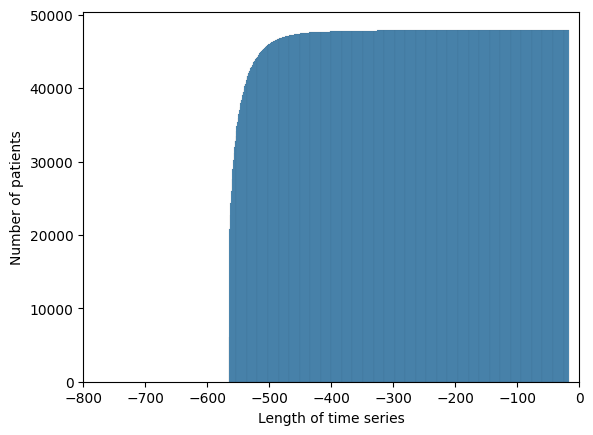

In [13]:
visualize(train['patientunitstayid'].values, xlim=(-800, 0), start_time = 60, end_time = 2880)            # use negatives in order to view >= as cumulative distribution

### Training

extract with time interval of 5

In [14]:
result = lets_extract(train['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564)
result.shape

Extracting...: 100%|██████████| 127939/127939 [08:53<00:00, 239.77it/s]


(20230, 9, 564)

In [16]:
result3 = lets_extract(train['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276)
result3.shape

Extracting...: 100%|██████████| 127939/127939 [07:22<00:00, 288.82it/s]


(46778, 9, 276)

In [18]:
import torch
torch.save(torch.tensor(result.astype(np.float64)), 'data/eicu-extract/TRAIN-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(result3.astype(np.float64)), 'data/eicu-extract/TRAIN-eicu_multiple_60_1440_276.pt')

### Testing

use same procedure as training set

In [24]:
test_48hrs = lets_extract(test['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, mode='test')
test_48hrs.shape

Extracting...: 100%|██████████| 42647/42647 [04:55<00:00, 144.54it/s]


(6705, 9, 564)

In [25]:
test_24hrs = lets_extract(test['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, mode='test')
test_24hrs.shape

Extracting...: 100%|██████████| 42647/42647 [04:46<00:00, 148.70it/s]


(15675, 9, 276)

In [26]:
import torch
torch.save(torch.tensor(test_48hrs.astype(np.float64)), 'data/eicu-extract/TEST-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(test_24hrs.astype(np.float64)), 'data/eicu-extract/TEST-eicu_multiple_60_1440_276.pt')

## Sub-populations

In [33]:
train_sepsis_id = train[train['sepsis'] ==1][['patientunitstayid', 'hospital_expire_flag']]
train_ami_id = train[train['ami'] ==1][['patientunitstayid', 'hospital_expire_flag']]
train_heart_failure_id = train[train['heart_failure'] ==1][['patientunitstayid', 'hospital_expire_flag']]
train_akf_id = train[train['akf'] ==1][['patientunitstayid', 'hospital_expire_flag']]

test_sepsis_id = test[test['sepsis'] ==1][['patientunitstayid', 'hospital_expire_flag']]
test_ami_id = test[test['ami'] ==1][['patientunitstayid', 'hospital_expire_flag']]
test_heart_failure_id = test[test['heart_failure'] ==1][['patientunitstayid', 'hospital_expire_flag']]
test_akf_id = test[test['akf'] ==1][['patientunitstayid', 'hospital_expire_flag']]

print(f"*** TRAINING ***\nNumber of sepsis patients: {len(train_sepsis_id)}\nNumber of ami patients: {len(train_ami_id)}\nNumber of heart failure patients: {len(train_heart_failure_id)}\nNumber of akf patients: {len(train_akf_id)}\n")
print(f"*** TESTING ***\nNumber of sepsis patients: {len(test_sepsis_id)}\nNumber of ami patients: {len(test_ami_id)}\nNumber of heart failure patients: {len(test_heart_failure_id)}\nNumber of akf patients: {len(test_akf_id)}")

*** TRAINING ***
Number of sepsis patients: 18419
Number of ami patients: 7549
Number of heart failure patients: 12478
Number of akf patients: 14455

*** TESTING ***
Number of sepsis patients: 6111
Number of ami patients: 2541
Number of heart failure patients: 4143
Number of akf patients: 4719


save those IDs

In [34]:
train_sepsis_id.to_csv("data/eicu-extract/TRAIN-sepsis_id.csv", index=False)
train_ami_id.to_csv("data/eicu-extract/TRAIN-ami_id.csv", index=False)
train_heart_failure_id.to_csv("data/eicu-extract/TRAIN-heart_failure_id.csv", index=False)
train_akf_id.to_csv("data/eicu-extract/TRAIN-akf_id.csv", index=False)

test_sepsis_id.to_csv("data/eicu-extract/TEST-sepsis_id.csv", index=False)
test_ami_id.to_csv("data/eicu-extract/TEST-ami_id.csv", index=False)
test_heart_failure_id.to_csv("data/eicu-extract/TEST-heart_failure_id.csv", index=False)
test_akf_id.to_csv("data/eicu-extract/TEST-akf_id.csv", index=False)

### Training

Sepsis/Septicemia

In [35]:
import pandas as pd
train_sepsis_id = pd.read_csv("data/eicu-extract/TRAIN-sepsis_id.csv")
train_ami_id = pd.read_csv("data/eicu-extract/TRAIN-ami_id.csv")
train_hear_failure_id = pd.read_csv("data/eicu-extract/TRAIN-heart_failure_id.csv")
train_akf_id = pd.read_csv("data/eicu-extract/TRAIN-akf_id.csv")

train_sepsis_48hrs = lets_extract(train_sepsis_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=train_sepsis_id)
train_sepsis_48hrs.shape

Extracting...:   0%|          | 0/18419 [00:00<?, ?it/s]

Extracting...: 100%|██████████| 18419/18419 [02:17<00:00, 133.54it/s]


(4839, 9, 564)

In [36]:
train_sepsis_24hrs = lets_extract(train_sepsis_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=train_sepsis_id)
train_sepsis_24hrs.shape

Extracting...: 100%|██████████| 18419/18419 [02:21<00:00, 130.09it/s]


(8813, 9, 276)

In [37]:
import torch
torch.save(torch.tensor(train_sepsis_48hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-SEPSIS-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(train_sepsis_24hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-SEPSIS-eicu_multiple_60_1440_276.pt')

Acite Myocardial Infarction

In [38]:
train_ami_48hrs = lets_extract(train_ami_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=train_ami_id)
train_ami_48hrs.shape

Extracting...: 100%|██████████| 7549/7549 [00:49<00:00, 153.75it/s]


(1183, 9, 564)

In [39]:
train_ami_24hrs = lets_extract(train_ami_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=train_ami_id)
train_ami_24hrs.shape

Extracting...: 100%|██████████| 7549/7549 [00:47<00:00, 158.22it/s]


(2927, 9, 276)

In [40]:
import torch
torch.save(torch.tensor(train_ami_48hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-AMI-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(train_ami_24hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-AMI-eicu_multiple_60_1440_276.pt')

Heart Failure

In [41]:
train_heart_failure_48hrs = lets_extract(train_heart_failure_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=train_heart_failure_id)
train_heart_failure_48hrs.shape

Extracting...: 100%|██████████| 12478/12478 [01:34<00:00, 131.70it/s]


(3156, 9, 564)

In [42]:
train_heart_failure_24hrs = lets_extract(train_heart_failure_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=train_heart_failure_id)
train_heart_failure_24hrs.shape

Extracting...: 100%|██████████| 12478/12478 [01:34<00:00, 132.59it/s]


(6102, 9, 276)

In [43]:
import torch
torch.save(torch.tensor(train_heart_failure_48hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-HF-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(train_heart_failure_24hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-HF-eicu_multiple_60_1440_276.pt')

Acute Kidney Failure

In [44]:
train_akf_48hrs = lets_extract(train_akf_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=train_akf_id)
train_akf_48hrs.shape

Extracting...: 100%|██████████| 14455/14455 [01:56<00:00, 124.37it/s]


(3856, 9, 564)

In [45]:
train_akf_24hrs = lets_extract(train_akf_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=train_akf_id)
train_akf_24hrs.shape

Extracting...: 100%|██████████| 14455/14455 [01:53<00:00, 127.23it/s]


(6981, 9, 276)

In [46]:
import torch
torch.save(torch.tensor(train_akf_48hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-AKF-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(train_akf_24hrs.astype(np.float64)), 'data/eicu-extract/TRAIN-AKF-eicu_multiple_60_1440_276.pt')

### Testing

Sepsis/Septicemia

In [47]:
import pandas as pd
test_sepsis_id = pd.read_csv("data/eicu-extract/TEST-sepsis_id.csv")
test_ami_id = pd.read_csv("data/eicu-extract/TEST-ami_id.csv")
test_hear_failure_id = pd.read_csv("data/eicu-extract/TEST-heart_failure_id.csv")
test_akf_id = pd.read_csv("data/eicu-extract/TEST-akf_id.csv")

test_sepsis_48hrs = lets_extract(test_sepsis_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=test_sepsis_id)
test_sepsis_48hrs.shape

Extracting...: 100%|██████████| 6111/6111 [00:45<00:00, 133.55it/s]


(1568, 9, 564)

In [48]:
test_sepsis_24hrs = lets_extract(test_sepsis_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=test_sepsis_id)
test_sepsis_24hrs.shape

Extracting...: 100%|██████████| 6111/6111 [00:41<00:00, 146.09it/s]


(2858, 9, 276)

In [49]:
import torch
torch.save(torch.tensor(test_sepsis_48hrs.astype(np.float64)), 'data/eicu-extract/TEST-SEPSIS-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(test_sepsis_24hrs.astype(np.float64)), 'data/eicu-extract/TEST-SEPSIS-eicu_multiple_60_1440_276.pt')

Acute Myocardial Infarction

In [50]:
test_ami_48hrs = lets_extract(test_ami_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=test_ami_id)
test_ami_48hrs.shape

Extracting...: 100%|██████████| 2541/2541 [00:17<00:00, 146.12it/s]


(382, 9, 564)

In [53]:
test_ami_24hrs = lets_extract(test_ami_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=test_ami_id)
test_ami_24hrs.shape

Extracting...: 100%|██████████| 2541/2541 [00:16<00:00, 151.23it/s]


(953, 9, 276)

In [54]:
import torch
torch.save(torch.tensor(test_ami_48hrs.astype(np.float64)), 'data/eicu-extract/TEST-AMI-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(test_ami_24hrs.astype(np.float64)), 'data/eicu-extract/TEST-AMI-eicu_multiple_60_1440_276.pt')

Heart Failure

In [55]:
test_heart_failure_48hrs = lets_extract(test_heart_failure_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=test_heart_failure_id)
test_heart_failure_48hrs.shape

Extracting...: 100%|██████████| 4143/4143 [00:29<00:00, 138.76it/s]


(1064, 9, 564)

In [56]:
test_heart_failure_24hrs = lets_extract(test_heart_failure_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=test_heart_failure_id)
test_heart_failure_24hrs.shape

Extracting...: 100%|██████████| 4143/4143 [00:28<00:00, 147.22it/s]


(2090, 9, 276)

In [57]:
import torch
torch.save(torch.tensor(test_heart_failure_48hrs.astype(np.float64)), 'data/eicu-extract/TEST-HF-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(test_heart_failure_24hrs.astype(np.float64)), 'data/eicu-extract/TEST-HF-eicu_multiple_60_1440_276.pt')

Acute Kidney Failure

In [58]:
test_akf_48hrs = lets_extract(test_akf_id['patientunitstayid'].values, start_time=60, end_time=2880, timesteps=564, data_frame=test_akf_id)
test_akf_48hrs.shape

Extracting...: 100%|██████████| 4719/4719 [00:35<00:00, 131.14it/s]


(1276, 9, 564)

In [59]:
test_akf_24hrs = lets_extract(test_akf_id['patientunitstayid'].values, start_time=60, end_time=1440, timesteps=276, data_frame=test_akf_id)
test_akf_24hrs.shape

Extracting...: 100%|██████████| 4719/4719 [00:35<00:00, 134.42it/s]


(2270, 9, 276)

In [60]:
import torch
torch.save(torch.tensor(test_akf_48hrs.astype(np.float64)), 'data/eicu-extract/TEST-AKF-eicu_multiple_60_2880_564.pt')
torch.save(torch.tensor(test_akf_24hrs.astype(np.float64)), 'data/eicu-extract/TEST-AKF-eicu_multiple_60_1440_276.pt')